In [1]:
# Harness CI Runner can automatically change values for some variable. For example is_local_development to False and tree_method to hist
is_local_development = True 
#tree_method = 'auto'
notebook_dir = 'notebooks'
model_name = 'xgb'

## Import Modules

In [2]:
import pandas as pd
import numpy as np
import mlflow
import logging
import joblib, datetime, os, time, yaml
from os import environ as env


In [3]:
logging.basicConfig(level=logging.INFO, format="%(asctime)-15s %(message)s")
logger = logging.getLogger()

## Parameters Configuration

In [4]:
#Set Working Dir and Data Dir
original_cwd = os.getcwd()

if not is_local_development:
    
    os.chdir(notebook_dir)
    os.getcwd()
    
print(os.getcwd())


/Users/shobhitverma/python/example-mlops/example-mlops/Notebooks


In [5]:
with open("../config.yml", "r") as file:
    cfg = yaml.safe_load(file)

#Modeling Parameters
outcome = cfg["modeling"]["outcome"]
tree_method = cfg["modeling"]["tree_method"]

#Optuna Parameters
n_trials = cfg["optuna"]["n_trials"] # Number of trials for hyperparameter optimization
model_file_name = cfg["optuna"]["model_file_name"] 

#ML Flow Parameters
experiment_name = cfg["mlflow"]["experiment_name"]
run_name = cfg["mlflow"]["run_name"]


In [6]:
# Import necessary libraries
import joblib
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import load_iris



# Load the Iris dataset
data = load_iris()
X, y = data.data, data.target

# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the objective function for hyperparameter optimization
def objective(trial):
    # Define the parameter space for the XGBoost classifier
    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "alpha": trial.suggest_float("alpha", 0, 5),
        "lambda": trial.suggest_float("lambda", 0, 5),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "eta": trial.suggest_float("eta", 0.01, 0.5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "seed": 42,  # Fixed seed for reproducibility
        "n_jobs": 4,  # Adjust based on your system's capabilities
        "tree_method": tree_method
    }

    # Initialize and evaluate the XGBoost classifier
    model = xgb.XGBClassifier(**param)
    score = cross_val_score(model, x_train, y_train, cv=3, scoring="neg_log_loss").mean()
    return score

# Initialize an Optuna study object
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)

# Output the results of the optimization
print("Optimization Results:")
print(f"Number of trials: {len(study.trials)}")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best trial score: {study.best_trial.value}")
print("Best trial parameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Fit the model based on the best trial parameters
best_model = xgb.XGBClassifier(**study.best_trial.params)
best_model.fit(x_train, y_train)

# Save the best model to a file
joblib.dump(best_model, model_file_name)
print(f"\nModel saved as '{model_file_name}'")



[I 2024-02-23 07:03:29,921] A new study created in memory with name: no-name-a5324996-09a8-4f73-ae08-79e62e05d442
[I 2024-02-23 07:03:30,423] Trial 0 finished with value: -1.0966846704690838 and parameters: {'alpha': 4.353063698625409, 'lambda': 0.8125180353515066, 'gamma': 3.4466390929167288, 'eta': 0.13669543520351987, 'colsample_bytree': 0.5782976742572514, 'subsample': 0.5959559651690274, 'n_estimators': 996, 'max_depth': 8, 'min_child_weight': 20}. Best is trial 0 with value: -1.0966846704690838.
[I 2024-02-23 07:03:30,910] Trial 1 finished with value: -0.6910261889020494 and parameters: {'alpha': 2.7952489239516094, 'lambda': 2.7344592513718173, 'gamma': 4.387467318445847, 'eta': 0.2644465335066051, 'colsample_bytree': 0.9590410100836007, 'subsample': 0.8297164971289972, 'n_estimators': 693, 'max_depth': 10, 'min_child_weight': 11}. Best is trial 1 with value: -0.6910261889020494.
[I 2024-02-23 07:03:31,742] Trial 2 finished with value: -0.45169765222871067 and parameters: {'alph

Optimization Results:
Number of trials: 12
Best trial number: 4
Best trial score: -0.31306628531113345
Best trial parameters:
  alpha: 0.450075627875684
  lambda: 0.7543855889925344
  gamma: 2.368504182243276
  eta: 0.47112932997141443
  colsample_bytree: 0.6594865657069624
  subsample: 0.8316320569576172
  n_estimators: 220
  max_depth: 3
  min_child_weight: 3

Model saved as 'xbg_model.joblib'


## Optuna Visualization Plots

/var/folders/q4/j_07mfg51sj19qv2jkml83gh0000gp/T/ipykernel_93445/3099221358.py:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = ov_matplotlib.plot_optimization_history(study)
/var/folders/q4/j_07mfg51sj19qv2jkml83gh0000gp/T/ipykernel_93445/3099221358.py:8: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig = ov_matplotlib.plot_parallel_coordinate(study)
/var/folders/q4/j_07mfg51sj19qv2jkml83gh0000gp/T/ipykernel_93445/3099221358.py:12: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = ov_matplotlib.plot_param_importances(study)


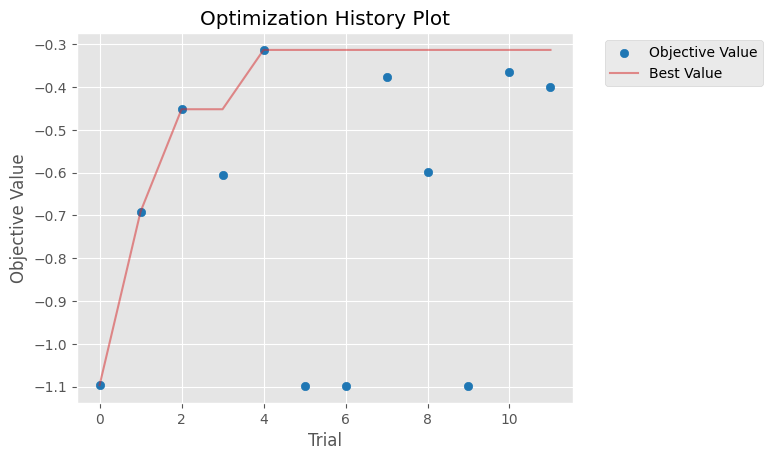

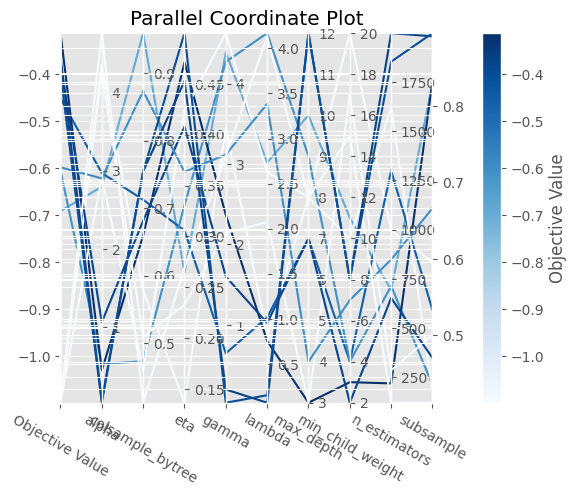

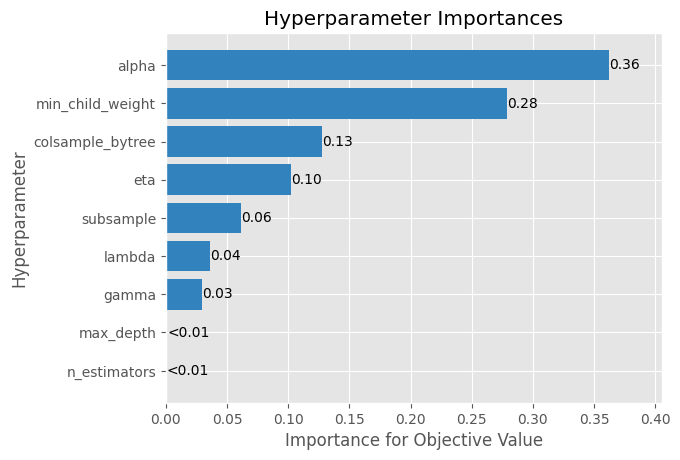

In [7]:
import optuna.visualization.matplotlib as ov_matplotlib

# Optimization History
fig = ov_matplotlib.plot_optimization_history(study)
fig.figure.savefig('optimization_history.jpg')

# Parallel Coordinate
fig = ov_matplotlib.plot_parallel_coordinate(study)
fig.figure.savefig('parallel_coordinate.jpg')

# Parameter Importance
fig = ov_matplotlib.plot_param_importances(study)
fig.figure.savefig('param_importances.jpg')


In [8]:
data['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

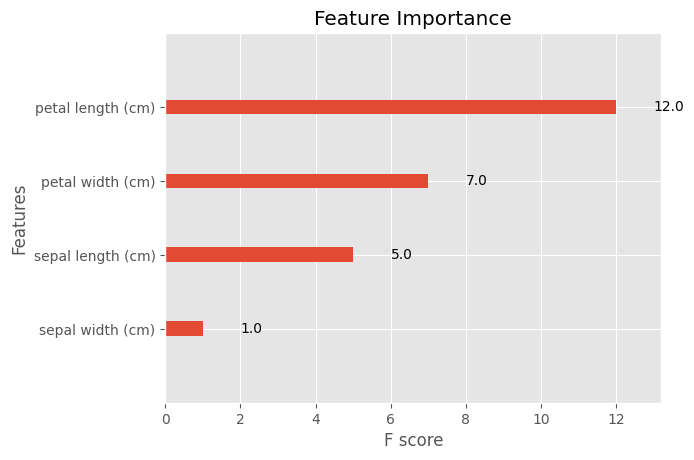

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

# After fitting the best model
best_model.get_booster().feature_names = data['feature_names']

xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()
plt.savefig('Feature Importance.jpg')

In [10]:
importances = best_model.feature_importances_
importances = pd.Series(importances, index=data['feature_names'])
importances

sepal length (cm)    0.244881
sepal width (cm)     0.097371
petal length (cm)    0.388605
petal width (cm)     0.269143
dtype: float32

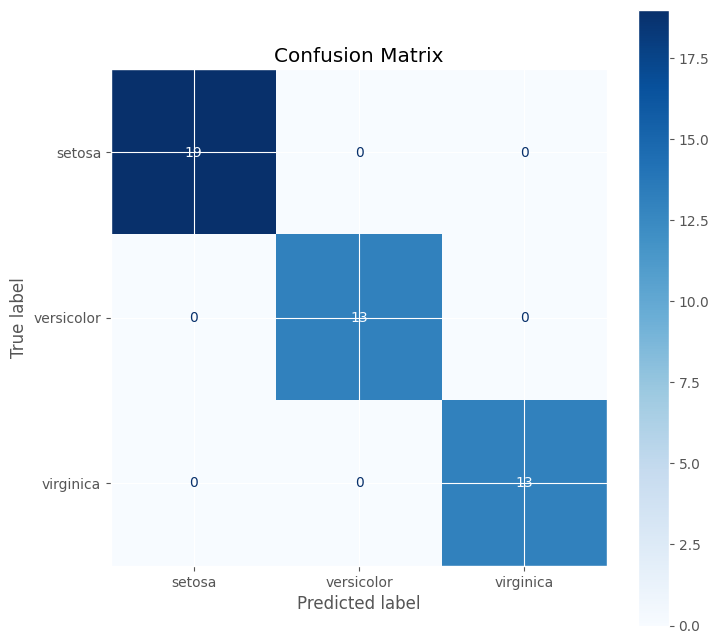

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(y_test, best_model.predict(x_test))

# Plot using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
#plt.savefig('/mnt/data/confusion_matrix.jpg')
plt.show()

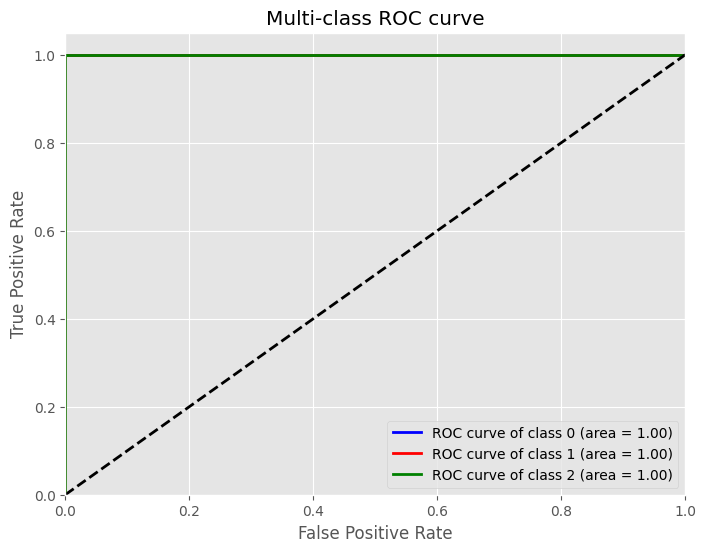

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]
y_score = best_model.predict_proba(x_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.savefig('multi_class_roc_curve.jpg')


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions
y_pred = best_model.predict(x_test)
y_proba = best_model.predict_proba(x_test)

# Basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# You can create a dictionary or similar structure to hold these metrics
model_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}



In [14]:
model_metrics

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

In [15]:
#Generate requirements.txt
! pip3 freeze > requirements.txt

In [16]:
# MLFlow Parameters
mlflow.set_experiment(experiment_name)

##Log the Model to MLFlow
mlflow.start_run(run_name=run_name)

# Log Parameters
mlflow.log_params(
    {
        "model_type": model_name,
        "n_features": X.shape[1],
        "importances": importances
    }
)

# Log Metrics
mlflow.log_metrics(
    model_metrics
)

# Log Artifacts
mlflow.log_artifact(f"{model_file_name}")
mlflow.log_artifact(f"requirements.txt")

mlflow.end_run()

In [17]:
mlflow.end_run()